In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB3,ResNet50,ResNet50V2,VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, BatchNormalization,Dropout,Flatten,Input,Conv2D

import warnings
warnings.filterwarnings('ignore')

# Prepare Dataset

In [2]:
data_train = pd.read_csv('/kaggle/input/my-seminar-dataset/data_train.csv')
data_valid = pd.read_csv('/kaggle/input/my-seminar-dataset/data_valid.csv')
data_test = pd.read_csv('/kaggle/input/my-seminar-dataset/data_test.csv')

#shuffling datasets
data_train = data_train.sample(frac = 1,ignore_index = True)
data_test = data_valid.sample(frac = 1,ignore_index = True)
data_valid = data_valid.sample(frac = 1,ignore_index = True)


df = [data_train,
#       data_test,
      data_valid]
for f in df:
    print(f.shape)
    display(f.head(3))

(1454, 8)


,img,healthy,leaf_rust,powdery_mildew,seedlings,septoria,stem_rust,yellow_rust
0,f9eba8dc0401f05c.jpg,0,0,0,0,0,1,0
1,fcd0f89c84c00d0c.jpg,0,1,1,0,0,0,0
2,e4e6e7e7e7e7e7e7.jpg,0,1,0,1,0,0,0


(480, 8)


,img,healthy,leaf_rust,powdery_mildew,seedlings,septoria,stem_rust,yellow_rust
0,c2cc0e9eb662c8c8.jpg,0,0,0,0,1,0,0
1,8f8d8d8d8d8c8c0d.jpg,0,0,0,0,0,1,0
2,6f7fb7399c362424.jpg,0,1,0,0,0,0,0


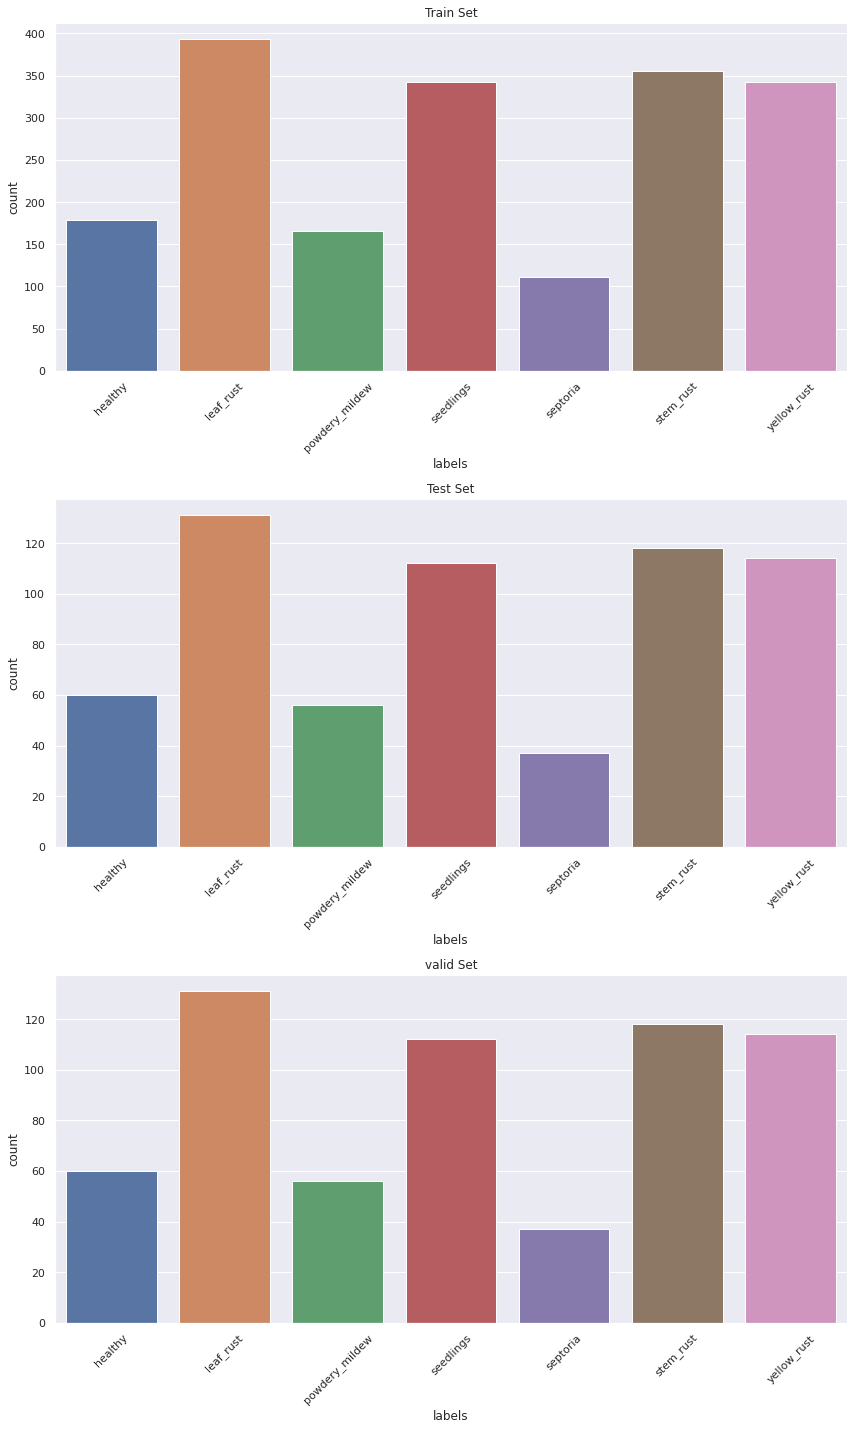

In [3]:
sns.set()

train_d = data_train.drop(columns = ['img'])
test_d = data_test.drop(columns = ['img'])
valid_d = data_valid.drop(columns = ['img'])

label_names = train_d.columns

cnt1 = (np.where(train_d == 1)[1])
cnt2 = (np.where(test_d == 1)[1])
cnt3 = (np.where(valid_d == 1)[1])

fig,ax = plt.subplots(3,1,figsize = [12,20])

sns.countplot(ax = ax[0],x = cnt1)
ax[0].set_xticklabels(label_names,rotation = 45)
ax[0].set_xlabel("labels")
ax[0].set_title("Train Set")

sns.countplot(ax = ax[1],x = cnt2)
ax[1].set_xticklabels(label_names,rotation = 45)
ax[1].set_xlabel("labels")
ax[1].set_title("Test Set")

sns.countplot(ax = ax[2],x = cnt3)
ax[2].set_xticklabels(label_names,rotation = 45)
ax[2].set_xlabel("labels")
ax[2].set_title("valid Set")

plt.tight_layout(pad = 1)

plt.show()




In [4]:
# def plot_count(data,name,color=  'blue'):
#     fd = data.drop(columns = ['img'])
#     t_labels = fd.columns
#     cnts = []
#     for i in t_labels:
#         cnt = (fd[fd[i] == 1]).shape[0]
#         cnts.append(cnt)
    
#     plt.figure(figsize=  [10,4], dpi = 90)
    
#     D = dict(zip(t_labels,cnts))
#     D = dict(sorted(D.items(), key=  lambda item: item[1]))
#     plt.bar(range(len(D)), list(D.values()), align='center',color= color)
#     plt.xticks(range(len(D)), list(D.keys()))
#     plt.title(name)
#     print("\n\n")
#     plt.show()

# plot_count(data_train,color = 'green',name = "train")
# plot_count(data_valid,color = 'crimson',name = "valid")

In [5]:
data_dir = "/kaggle/input/my-seminar-dataset/wfd_dataset/wfd_dataset/"
NUM_CLASSES = 7
batch_size = 32
IMG_SIZE = (224,224,3)
AUTOTUNE = tf.data.experimental.AUTOTUNE
LR = 1e-4
print(AUTOTUNE)

-1


In [6]:
# Required custom functions

def load_and_preprocess_image(filename):
    ''' Function to load and preprocess image '''
    image = tf.io.read_file((data_dir + filename))
    image = tf.io.decode_image(image,channels = 3,expand_animations = False)
    image = image / 255
    resized_image = tf.image.resize(image,[IMG_SIZE[0],IMG_SIZE[1]])
    return resized_image

def load_from_filename_label(filename,label): return (load_and_preprocess_image(filename),label)

def prepare(dataframe):
    ''' Takes dataframe and prepares dataset '''
    filenames = dataframe.iloc[:,0]
    labels = dataframe.iloc[:,1:]
    ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    return ds.map(load_from_filename_label)

def configure_for_performance(ds):
    ''' Convert whole dataset into batchs.
        For better internal loading  '''
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def show(filename):
    ''' displays image based on filename '''
    plt.figure()
    img = cv2.imread(str(data_dir + filename))
    plt.imshow(img)
    plt.show()

def plot(history,metric):
    ''' Plots the model performence '''
    acc = history.history[metric]
    val_acc = history.history[f'val_{metric}']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
            
    plt.figure(figsize=(12,5),dpi = 100)

    plt.subplot(121)
    plt.title(f'Training and Validation {metric}')
    plt.plot(acc, label=f'Training {metric}')
    plt.plot(val_acc, label=f'Validation {metric}')
    plt.legend(loc='upper left')
    plt.ylabel(f"{metric}")
    plt.ylim([min(plt.ylim()),1])
    plt.xlabel('epoch')
    

    plt.subplot(122)
    plt.title('Training and Validation Loss')
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper left')
    plt.ylabel('Cross Entropy')
    plt.xlabel('epoch')
    plt.show()
    #     plt.ylim([0,1.0])
    
    

def get_results(model,train_ds,valid_ds):
    train_loss , train_acc = model.evaluate(train_ds,steps = 16)
    valid_loss , valid_acc = model.evaluate(valid_ds,steps = 16)
    results = {
            "train":{
                "acc":train_acc,
                "loss":train_loss
            },
            "validation":{
                "acc":valid_acc,
                "loss":valid_loss
            }
        }
    return results

In [7]:
train_ds = prepare(data_train)
valid_ds = prepare(data_valid)

train_ds = configure_for_performance(train_ds)
valid_ds = configure_for_performance(valid_ds)

2022-12-14 11:08:26.576325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 11:08:26.674649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 11:08:26.675745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 11:08:26.679017: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
# for batch, labels in (train_ds.take(1)):
#     print(len(batch))
#     print(batch,labels)
#     break

# Model Building

# ConvNet

In [10]:
def convolutionalNetwork(input_shape):
    '''This is a custom built network inspired from VGG16 paper'''
    convmodel = Sequential(name= 'convolutional_neural_network')

    convmodel.add(Input(shape=input_shape))

    convmodel.add(Conv2D(64, (3, 3), activation='relu'))
    convmodel.add(Conv2D(64, (3, 3), activation='relu'))
    convmodel.add(layers.MaxPooling2D((2, 2)))
    convmodel.add(BatchNormalization())

    convmodel.add(Conv2D(256, (3, 3), activation='relu'))
    convmodel.add(Conv2D(256, (3, 3), activation='relu'))
    convmodel.add(Conv2D(256, (3, 3), activation='relu'))
    convmodel.add(layers.MaxPooling2D((2, 2)))
    convmodel.add(BatchNormalization())
    
    convmodel.add(Conv2D(512, (3, 3), activation='relu'))
    convmodel.add(Conv2D(512, (3, 3), activation='relu'))
    convmodel.add(layers.MaxPooling2D((3, 3)))
    convmodel.add(BatchNormalization())
    
    convmodel.add(Conv2D(512, (3, 3), activation='relu'))
    convmodel.add(layers.GlobalAveragePooling2D())
    
    convmodel.add(Dense(1000, activation='relu'))
    convmodel.add(Dense(NUM_CLASSES, activation='sigmoid'))
    
    return convmodel

Model: "ConvNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
convolutional_neural_network (None, 7)                 7789703   
Total params: 7,789,703
Trainable params: 7,788,039
Non-trainable params: 1,664
_________________________________________________________________
Epoch 1/40


2022-12-13 06:01:58.972040: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-13 06:02:09.423577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 75 of 1000
2022-12-13 06:02:19.416725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 158 of 1000
2022-12-13 06:02:29.710183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 241 of 1000
2022-12-13 06:02:39.535773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 307 of 1000
Cleanup called...
2022-12-13 06:02:49.403589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 383 of 1000
2022-12-13 06:02:59.355390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:1

23/23 [==============================] - ETA: 0s - loss: 0.4747 - f1_score: 0.3344

2022-12-13 06:05:37.094016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 76 of 1000
2022-12-13 06:05:47.248385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 159 of 1000
2022-12-13 06:05:57.427962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 258 of 1000
2022-12-13 06:06:07.335730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 357 of 1000
2022-12-13 06:06:17.339696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 435 of 1000
2022-12-13 06:06:23.030391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


23/23 [==============================] - 273s 5s/step - loss: 0.4747 - f1_score: 0.3344 - val_loss: 0.5481 - val_f1_score: 0.2911
Epoch 2/40
23/23 [==============================] - 15s 639ms/step - loss: 0.3962 - f1_score: 0.4348 - val_loss: 0.4959 - val_f1_score: 0.3078
Epoch 3/40
23/23 [==============================] - 15s 641ms/step - loss: 0.3905 - f1_score: 0.4481 - val_loss: 0.4690 - val_f1_score: 0.2998
Epoch 4/40
23/23 [==============================] - 15s 640ms/step - loss: 0.3738 - f1_score: 0.4706 - val_loss: 0.5838 - val_f1_score: 0.2135
Epoch 5/40
23/23 [==============================] - 15s 640ms/step - loss: 0.3550 - f1_score: 0.4963 - val_loss: 0.5897 - val_f1_score: 0.2108
Epoch 6/40
23/23 [==============================] - 15s 642ms/step - loss: 0.3623 - f1_score: 0.4926 - val_loss: 0.4778 - val_f1_score: 0.2573
Epoch 7/40
23/23 [==============================] - 15s 637ms/step - loss: 0.3513 - f1_score: 0.5099 - val_loss: 0.6081 - val_f1_score: 0.1423
Epoch 8/40
2

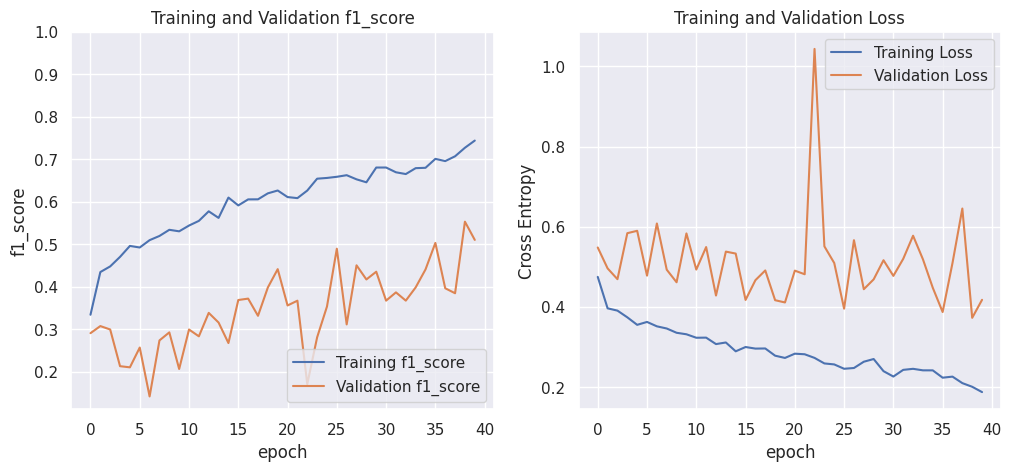

16/16 [==============================] - 3s 177ms/step - loss: 0.3067 - f1_score: 0.6237
[0.3066839277744293, 0.6237271428108215]
16/16 [==============================] - 1s 79ms/step - loss: 0.4175 - f1_score: 0.5104
[0.41746991872787476, 0.5104340314865112]


In [11]:
EPOCHS  = 40
IMG_SIZE = (224,224,3)


base_model = convolutionalNetwork(IMG_SIZE)
# base_model.summary()

augmentation_layers = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.4),
    layers.RandomContrast(0.7)
],name="data_augmentation")


convModel = Sequential([augmentation_layers,base_model], name = "ConvNet")
convModel.build(((None,) + IMG_SIZE))
convModel.summary()


######
optimizer = Adam(learning_rate = 6e-4)
loss = tf.keras.losses.BinaryCrossentropy()
f1_score = tfa.metrics.F1Score(num_classes= NUM_CLASSES, average='macro',threshold = 0.25)

es = EarlyStopping(monitor = f1_score, 
                   mode = 'max', 
                   verbose = 1, 
                   patience = 10,
                   restore_best_weights = True)

mc = ModelCheckpoint('best_model.h5',
                     monitor = f1_score, 
                     mode='max',
                     verbose = 1, 
                     save_best_only = True)

callback_list = [es,mc]
######


convModel.compile(optimizer,loss ,metrics=[f1_score])
history_ft = convModel.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS, callbacks = callback_list)
plot(history_ft,metric = "f1_score")

print(convModel.evaluate(train_ds,steps = 16))
print(convModel.evaluate(valid_ds,steps = 16))

In [12]:
convModel.save("best_model_ConvNet_tf1_62_vf1_51.h5")

## EfficientNet B3

2022-12-14 12:44:27.659015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 12:44:27.790793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 12:44:27.791614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 12:44:27.796336: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

43950080/43941136 [==============================] - 3s 0us/step
Model: "EfficientNetB3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 300, 300, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
output_layer (Dense)         (None, 7)                 10759     
Total params: 10,800,438
Trainable params: 13,831
Non

2022-12-14 12:44:44.520624: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-14 12:44:55.811625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 75 of 1000
2022-12-14 12:45:06.122805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 151 of 1000
2022-12-14 12:45:15.770204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 237 of 1000
Cleanup called...
2022-12-14 12:45:25.662182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 315 of 1000
2022-12-14 12:45:35.867115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 400 of 1000
2022-12-14 12:45:45.839347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:1

46/46 [==============================] - ETA: 0s - loss: 0.8125 - accuracy: 0.1781

2022-12-14 12:48:13.462074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 76 of 1000
2022-12-14 12:48:23.427221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 158 of 1000
2022-12-14 12:48:33.333103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 248 of 1000
2022-12-14 12:48:43.520426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 328 of 1000
2022-12-14 12:48:53.430628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 395 of 1000
2022-12-14 12:49:03.408179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 478 of 1000
2022-12-14 12:49:03.577703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled

46/46 [==============================] - 268s 3s/step - loss: 0.8125 - accuracy: 0.1781 - val_loss: 0.4847 - val_accuracy: 0.1792
Epoch 2/20
46/46 [==============================] - 9s 186ms/step - loss: 0.6141 - accuracy: 0.1836 - val_loss: 0.4816 - val_accuracy: 0.1500
Epoch 3/20
46/46 [==============================] - 8s 182ms/step - loss: 0.6125 - accuracy: 0.1871 - val_loss: 0.4948 - val_accuracy: 0.1792
Epoch 4/20
46/46 [==============================] - 8s 181ms/step - loss: 0.6020 - accuracy: 0.1726 - val_loss: 0.4950 - val_accuracy: 0.1792
Epoch 5/20
46/46 [==============================] - 8s 181ms/step - loss: 0.5897 - accuracy: 0.1857 - val_loss: 0.5051 - val_accuracy: 0.2729
Epoch 6/20
46/46 [==============================] - 8s 183ms/step - loss: 0.5596 - accuracy: 0.1878 - val_loss: 0.4849 - val_accuracy: 0.2646
Epoch 7/20
46/46 [==============================] - 8s 182ms/step - loss: 0.5446 - accuracy: 0.1768 - val_loss: 0.4748 - val_accuracy: 0.1500
Epoch 8/20
46/46 [

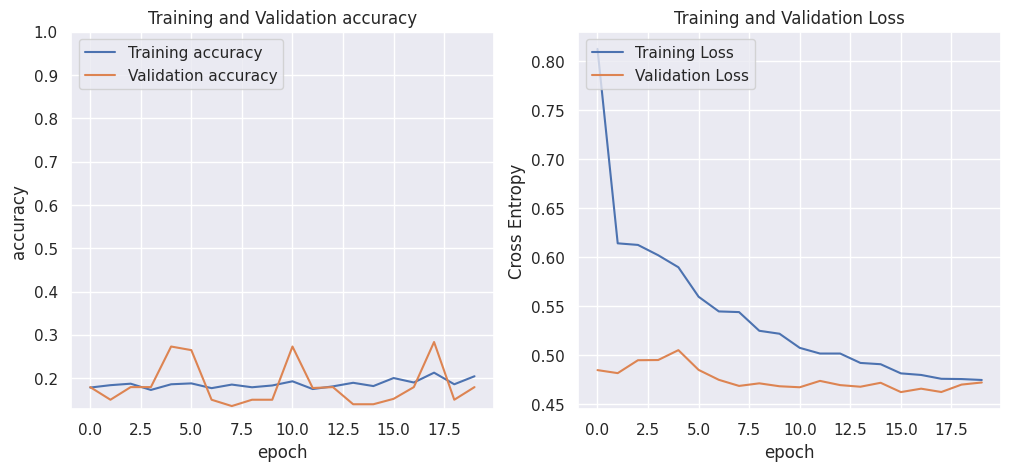

Epoch 21/50
46/46 [==============================] - 53s 856ms/step - loss: 0.4386 - accuracy: 0.2909 - val_loss: 0.4720 - val_accuracy: 0.1792

Epoch 00021: val_accuracy improved from -inf to 0.17917, saving model to best_model.h5
Epoch 22/50
46/46 [==============================] - 37s 796ms/step - loss: 0.3696 - accuracy: 0.4484 - val_loss: 0.4676 - val_accuracy: 0.1813

Epoch 00022: val_accuracy improved from 0.17917 to 0.18125, saving model to best_model.h5
Epoch 23/50
46/46 [==============================] - 37s 794ms/step - loss: 0.3248 - accuracy: 0.5062 - val_loss: 0.4668 - val_accuracy: 0.1375

Epoch 00023: val_accuracy did not improve from 0.18125
Epoch 24/50
46/46 [==============================] - 37s 794ms/step - loss: 0.2837 - accuracy: 0.5805 - val_loss: 0.4784 - val_accuracy: 0.2438

Epoch 00024: val_accuracy improved from 0.18125 to 0.24375, saving model to best_model.h5
Epoch 25/50
46/46 [==============================] - 37s 799ms/step - loss: 0.2529 - accuracy: 0.6

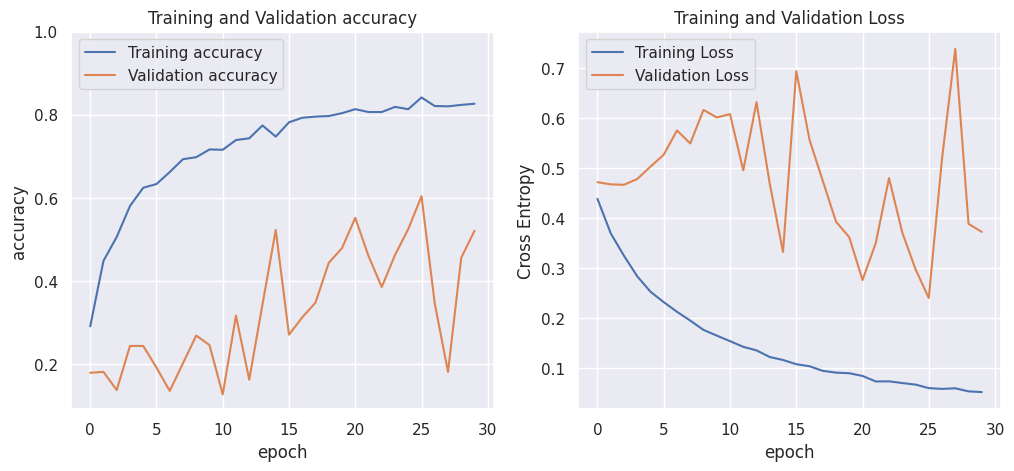

16/16 [==============================] - 2s 128ms/step - loss: 0.2534 - accuracy: 0.6016
[0.2534082233905792, 0.6015625]
16/16 [==============================] - 2s 122ms/step - loss: 0.3726 - accuracy: 0.5208
[0.37256744503974915, 0.5208333134651184]


In [7]:
EPOCHS  = 20
EPOCHS_FT = EPOCHS + 30
# IMG_SIZE = (224,224,3)
IMG_SIZE = (300,300,3)

train_ds = prepare(data_train)
valid_ds = prepare(data_valid)

train_ds = configure_for_performance(train_ds)
valid_ds = configure_for_performance(valid_ds)


base_model = EfficientNetB3(input_shape = (IMG_SIZE),include_top = False,weights = 'imagenet',drop_connect_rate=0.4)

base_model.trainable = False
# for layer in base_model.layers[-15:]:
#     layer.trainable = True
#     if not isinstance(layer,layers.BatchNormalization):
#         layer.trainable = True


augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomContrast(0.3)
],name="data_augmentation")

effb1Model = Sequential([    
    augmentation,
    
    base_model,
    
    GlobalAveragePooling2D(),
    BatchNormalization(),
#     Dense(units = 1024,activation='relu'),
    Dropout(0.2),
    Dense(units = NUM_CLASSES, activation = 'sigmoid', name= 'output_layer')
],name = "EfficientNetB3")


effb1Model.build(((None,) + IMG_SIZE))
effb1Model.summary()


######
optimizer = Adam(learning_rate = 1e-2)
loss = tf.keras.losses.BinaryCrossentropy()
f1_score = tfa.metrics.F1Score(num_classes= NUM_CLASSES, average='macro',threshold = 0.25)

es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   verbose = 1, 
                   patience = 10,
                   restore_best_weights = True)

mc = ModelCheckpoint('best_model.h5',
                     monitor = 'val_accuracy', 
                     mode='max',
                     verbose = 1, 
                     save_best_only = True)

callback_list = [es,mc]
######


effb1Model.compile(optimizer,loss ,metrics=['accuracy'])
history = effb1Model.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS)
plot(history,metric = "accuracy")


#######################
#finetuning efficentNet
# base_model.trainable = True
for layer in effb1Model.layers[-20:]:
    if not isinstance(layer,layers.BatchNormalization):
        layer.trainable = True
    
ft_optimizers = Adam(learning_rate=8e-5)

effb1Model.compile(ft_optimizers, loss,metrics=['accuracy'])
history_ft = effb1Model.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS_FT, initial_epoch = EPOCHS,callbacks = callback_list)
plot(history_ft,metric = "accuracy")

print(effb1Model.evaluate(train_ds,steps = 16))
print(effb1Model.evaluate(valid_ds,steps = 16))

## ResNet50

In [ ]:
# ResNet50
EPOCHS  = 20
EPOCHS_FT = EPOCHS + 40
# LR = 5e-4

train_ds = prepare(data_train)
valid_ds = prepare(data_valid)

train_ds = configure_for_performance(train_ds)
valid_ds = configure_for_performance(valid_ds)

base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")
base_model.trainable = False

resmodel = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.Rescaling(1./255),
    
    base_model,
    
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.4),
    Dense(units = NUM_CLASSES,activation = 'sigmoid',name= 'output_layer')
],name = "ResNet50")


resmodel.build(((None,) + IMG_SIZE))
resmodel.summary()

Optimizer = tf.keras.optimizers.RMSprop(learning_rate = LR)
loss = tf.keras.losses.CategoricalCrossentropy()

resmodel.compile(optimizer = Optimizer,loss = loss,metrics=['accuracy'])
history = resmodel.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS)
plot(history)


#######################
#finetuning resnet50
base_model.trainable = True
resmodel.compile(optimizer = Optimizer,loss = loss,metrics=['accuracy'])
history_ft = resmodel.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS_FT, initial_epoch = EPOCHS)
plot(history_ft)

In [ ]:
#################################

modelName = resmodel.name

with open(f"{modelName}_result.txt","w") as file:
    file.write(str(get_results(resmodel,train_ds,valid_ds)))  
print(f"{modelName} Results written!")

# resmodel.save(f"{modelName}.h5")
# print(f"{modelName} saved ast .h5!")

print("Done")

# ResNet50V2

2022-12-09 06:51:33.892629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 06:51:34.080121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 06:51:34.081104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 06:51:34.083256: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94683136/94668760 [==============================] - 1s 0us/step
Model: "ResNet50V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
output_layer (Dense)         (None, 7)                 14343     
Total params: 23,587,335
Trainable params: 4,483,079
Non-

2022-12-09 06:51:44.018159: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-09 06:51:55.035475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 62 of 1000
2022-12-09 06:52:05.035767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 145 of 1000
2022-12-09 06:52:14.977546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 222 of 1000
2022-12-09 06:52:25.293431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 297 of 1000
2022-12-09 06:52:35.063756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 373 of 1000
2022-12-09 06:52:44.961050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shu

 2/23 [=>............................] - ETA: 35s - loss: 1.0626 - f1_score: 0.3193  

Cleanup called...


23/23 [==============================] - ETA: 0s - loss: 0.5732 - f1_score: 0.3863

2022-12-09 06:55:27.886211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 61 of 1000
2022-12-09 06:55:38.114309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 142 of 1000
2022-12-09 06:55:47.828976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 217 of 1000
2022-12-09 06:55:58.118584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 276 of 1000
2022-12-09 06:56:08.278344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 353 of 1000
2022-12-09 06:56:17.826902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 431 of 1000
2022-12-09 06:56:25.146425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled

23/23 [==============================] - 286s 6s/step - loss: 0.5732 - f1_score: 0.3863 - val_loss: 21.8692 - val_f1_score: 0.2444
Epoch 2/20
23/23 [==============================] - 4s 196ms/step - loss: 0.3444 - f1_score: 0.4799 - val_loss: 6.9653 - val_f1_score: 0.2843
Epoch 3/20
23/23 [==============================] - 4s 192ms/step - loss: 0.2919 - f1_score: 0.5615 - val_loss: 2.5335 - val_f1_score: 0.3363
Epoch 4/20
23/23 [==============================] - 4s 193ms/step - loss: 0.2622 - f1_score: 0.6152 - val_loss: 1.2824 - val_f1_score: 0.4484
Epoch 5/20
23/23 [==============================] - 5s 197ms/step - loss: 0.2505 - f1_score: 0.6634 - val_loss: 1.0631 - val_f1_score: 0.4545
Epoch 6/20
23/23 [==============================] - 4s 193ms/step - loss: 0.2303 - f1_score: 0.6851 - val_loss: 0.6260 - val_f1_score: 0.5515
Epoch 7/20
23/23 [==============================] - 4s 196ms/step - loss: 0.2135 - f1_score: 0.7201 - val_loss: 0.7636 - val_f1_score: 0.5070
Epoch 8/20
23/23 

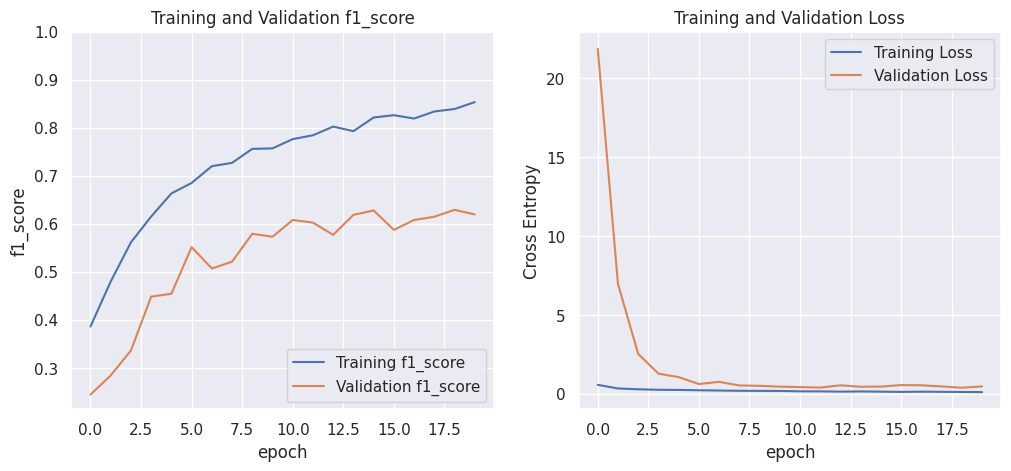

Epoch 21/60
23/23 [==============================] - 18s 489ms/step - loss: 0.2302 - f1_score: 0.7195 - val_loss: 0.4478 - val_f1_score: 0.6373
Epoch 22/60
23/23 [==============================] - 10s 428ms/step - loss: 0.1857 - f1_score: 0.7835 - val_loss: 0.4372 - val_f1_score: 0.6278
Epoch 23/60
23/23 [==============================] - 10s 426ms/step - loss: 0.1738 - f1_score: 0.7977 - val_loss: 0.4231 - val_f1_score: 0.6318
Epoch 24/60
23/23 [==============================] - 10s 426ms/step - loss: 0.1548 - f1_score: 0.8166 - val_loss: 0.4058 - val_f1_score: 0.6300
Epoch 25/60
23/23 [==============================] - 10s 429ms/step - loss: 0.1460 - f1_score: 0.8183 - val_loss: 0.3962 - val_f1_score: 0.6306
Epoch 26/60
23/23 [==============================] - 10s 425ms/step - loss: 0.1479 - f1_score: 0.8216 - val_loss: 0.3882 - val_f1_score: 0.6282
Epoch 27/60
23/23 [==============================] - 10s 426ms/step - loss: 0.1372 - f1_score: 0.8266 - val_loss: 0.3772 - val_f1_score:

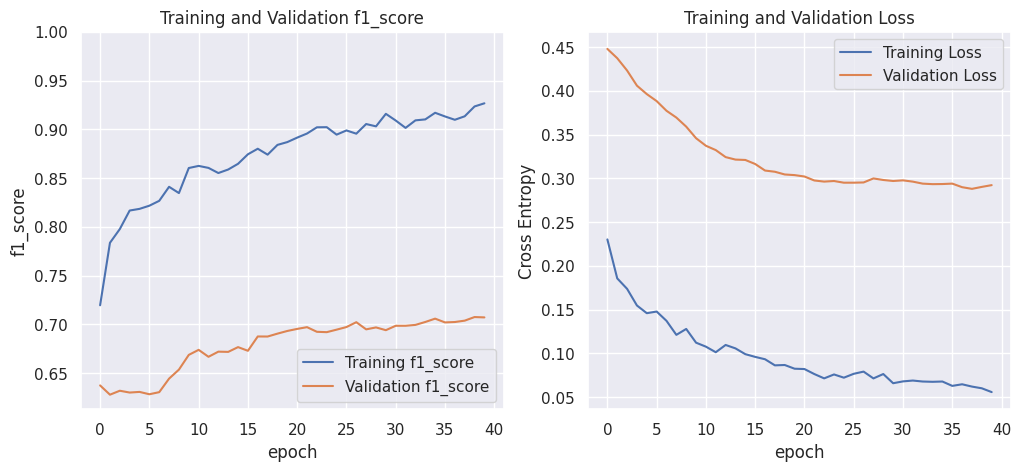

16/16 [==============================] - 2s 131ms/step - loss: 0.0519 - f1_score: 0.9281
[0.05191006883978844, 0.9281123876571655]
16/16 [==============================] - 1s 59ms/step - loss: 0.2922 - f1_score: 0.7070
[0.29223039746284485, 0.7070493698120117]


In [7]:
EPOCHS  = 20
EPOCHS_FT = EPOCHS + 40
IMG_SIZE = (256,256,3)

train_ds = prepare(data_train)
valid_ds = prepare(data_valid)



train_ds = configure_for_performance(train_ds)
valid_ds = configure_for_performance(valid_ds)

base_model = ResNet50V2(input_shape=IMG_SIZE, include_top=False, weights="imagenet")
for layer in base_model.layers[:-11]:
    layer.trainable = False

# print("#"*10)
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name, layer.trainable)
# print("#"*10)

augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.4),
    layers.RandomContrast(0.7)
],name="data_augmentation")

resv2model = Sequential([    
    augmentation,
    base_model,
    
    GlobalAveragePooling2D(),
    BatchNormalization(),
#     Dense(units = 1024,activation='relu'),
    Dropout(0.4),
    
    Dense(units = NUM_CLASSES, activation = 'sigmoid', name= 'output_layer')
],name = "ResNet50V2")


resv2model.build(((None,) + IMG_SIZE))
resv2model.summary()


######
loss = tf.keras.losses.BinaryCrossentropy()
# accuracy = tf.keras.metrics.Precision(top_k = 3)
f1_score = tfa.metrics.F1Score(num_classes= NUM_CLASSES, average='macro',threshold = 0.25)


es = EarlyStopping(monitor = f1_score, 
                   mode = 'max', 
                   verbose = 1, 
                   patience = 10,
                   restore_best_weights = True)

mc = ModelCheckpoint('best_model.h5',
                     monitor = f1_score, 
                     mode='max',
                     verbose = 1, 
                     save_best_only = True)

callback_list = [es,mc]
######

optimizer = Adam(learning_rate = 5e-3)
resv2model.compile(optimizer,loss ,metrics=[f1_score])
history = resv2model.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS)
plot(history,metric = "f1_score")


#######################
#finetuning resnet
base_model.trainable = True
    
# ft_optimizers = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.0, name="SGD")
ft_optimizers = Adam(learning_rate=1e-5)

resv2model.compile(ft_optimizers, loss,metrics=[f1_score])
history_ft = resv2model.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS_FT, initial_epoch = EPOCHS,callbacks = callback_list)
plot(history_ft,metric = "f1_score")

print(resv2model.evaluate(train_ds,steps = 16))
print(resv2model.evaluate(valid_ds,steps = 16))

In [8]:
resv2model.save("best_model_resnet50V2_tf1_92_vf1_70.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# VGG16

In [ ]:
EPOCHS  = 20
EPOCHS_FT = EPOCHS + 40

train_ds = prepare(data_train)
valid_ds = prepare(data_valid)

train_ds = configure_for_performance(train_ds)
valid_ds = configure_for_performance(valid_ds)

base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
for layer in base_model.layers[:-2]:
    layer.trainable = False

print("#"*10)
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)
print("#"*10)

augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.4),
    layers.RandomContrast(0.7)
],name="data_augmentation")

vggmodel = Sequential([    
    augmentation,
    base_model,
    
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(units = 1024,activation='relu'),
    Dropout(0.4),
    
    Dense(units = NUM_CLASSES, activation = 'sigmoid', name= 'output_layer')
],name = "VGG16")


vggmodel.build(((None,) + IMG_SIZE))
vggmodel.summary()


######
loss = tf.keras.losses.BinaryCrossentropy()
# accuracy = tf.keras.metrics.Precision(top_k = 3)
f1_score = tfa.metrics.F1Score(num_classes= NUM_CLASSES, average='macro',threshold = 0.25)


es = EarlyStopping(monitor = f1_score, 
                   mode = 'max', 
                   verbose = 1, 
                   patience = 10,
                   restore_best_weights = True)

mc = ModelCheckpoint('best_model.h5',
                     monitor = f1_score, 
                     mode='max',
                     verbose = 1, 
                     save_best_only = True)

callback_list = [es,mc]
######

optimizer = Adam(learning_rate = 5e-3)
vggmodel.compile(optimizer,loss ,metrics=[f1_score])
history = vggmodel.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS)
plot(history,metric = "f1_score")


#######################
#finetuning VGG16
base_model.trainable = True
    
# ft_optimizers = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.0, name="SGD")
ft_optimizers = Adam(learning_rate=7e-6)

vggmodel.compile(ft_optimizers, loss,metrics=[f1_score])
history_ft = vggmodel.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS_FT, initial_epoch = EPOCHS,callbacks = callback_list)
plot(history_ft,metric = "f1_score")

print(vggmodel.evaluate(train_ds,steps = 16))
print(vggmodel.evaluate(valid_ds,steps = 16))

In [ ]:
# vggmodel.save("best_model_vgg16_tf1_83_vf1_68.h5")

# Extra 

In [ ]:
# IMG_SIZE = (224,224,3)
# EPOCHS = 30
# LR = 1e-4

# train_ds = prepare(data_train)
# valid_ds = prepare(data_valid)

# print(f"Train set\t= {train_ds.cardinality().numpy()} samples")
# print(f"Valid set\t= {valid_ds.cardinality().numpy()}  samples")
# # print(f"Test set\t= {test_ds.cardinality().numpy()}  samples")


# train_ds = configure_for_performance(train_ds)
# valid_ds = configure_for_performance(valid_ds)

# # for image_batch, labels_batch in train_ds:
# #     print(image_batch.shape)
# #     print(labels_batch.shape)
# #     break
    

# base_model = EfficientNetB1(input_shape = (IMG_SIZE),include_top = False,weights = 'imagenet')
# base_model.trainable = False

# b1model = Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2),
#     layers.Rescaling(1./255),
    
#     base_model,
    
#     GlobalAveragePooling2D(),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(units = NUM_CLASSES,activation = 'sigmoid',name= 'output_layer')
# ],name = "EfficientNetB1")

# b1model.build(IMG_SIZE)
# b1model.summary()

# Optimizer = tf.keras.optimizers.RMSprop(learning_rate = LR)
# loss = tf.keras.losses.CategoricalCrossentropy()

# b1model.compile(optimizer = Optimizer,loss = loss,metrics=['accuracy'])
# history = b1model.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS)
# plot(history)

# print("\n" + "\033[1;3m STARTED TO FINETUNE...\n")

# #finetune

# base_model.trainable = True
# # fine_tune_at = 290

# # for layer in base_model.layers[:fine_tune_at]:
# #     layer.trainable = False

# b1model.compile(optimizer = Optimizer,loss = loss,metrics=['accuracy'])
# history_fine = b1model.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS + 30,initial_epoch = 30)
# plot(history_fine)

In [ ]:
# #################################

# modelName = b1model.name
# b1model.save(f"{modelName}.h5")
# print(f"{modelName} saved ast .h5!")

# with open(f"{modelName}_result.txt","w") as file:
#     file.write(str(get_results(b1model,train_ds,valid_ds)))  
# print(f"{modelName} Results written!")

# print("Done")

## InceptionV3

In [ ]:
#inceptionv3
# IMG_SIZE = (150,150,3)
# EPOCHS = 20
# NUM_CLASSES = 7
# LR = 1e-4

# train_ds = prepare(data_train)
# valid_ds = prepare(data_valid)

# train_ds = configure_for_performance(train_ds)
# valid_ds = configure_for_performance(valid_ds)


# base_model = InceptionV3(input_shape = (IMG_SIZE),include_top = False,weights = 'imagenet')
# base_model.trainable = False

# inmodel = Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2),
#     layers.Rescaling(1./255),
    
#     base_model,
    
#     GlobalAveragePooling2D(),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(units = NUM_CLASSES,activation = 'sigmoid',name= 'output_layer')
# ],name = "InceptionV3")


# inmodel.build(((None,) + IMG_SIZE))
# inmodel.summary()

# Optimizer = tf.keras.optimizers.RMSprop(learning_rate = LR)
# loss = tf.keras.losses.CategoricalCrossentropy()

# inmodel.compile(optimizer = Optimizer,loss = loss,metrics=['accuracy'])
# history = inmodel.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS)
# plot(history)


# # print("\n" + "\033[1;3m STARTED TO FINETUNE...\n")


# #finetuning
# base_model.trainable = True

# inmodel.build(((None,) + IMG_SIZE))
# # Optimizer = tf.keras.optimizers.RMSprop(learning_rate = 5e-4)
# # loss = tf.keras.losses.CategoricalCrossentropy()

# inmodel.compile(optimizer = Optimizer,loss = loss,metrics=['accuracy'])
# history_fine = inmodel.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS + 40,initial_epoch = 20)
# plot(history_fine)

In [ ]:
# #################################

# modelName = inmodel.name
# inmodel.save(f"{modelName}.h5")
# print(f"{modelName} saved ast .h5!")

# with open(f"{modelName}_result.txt","w") as file:
#     file.write(str(get_results(inmodel,train_ds,valid_ds)))  
# print(f"{modelName} Results written!")

# print("Done")

In [ ]:
# # inception without finetuning

# # train_ds = prepare(data_train)
# # valid_ds = prepare(data_valid)

# # train_ds = configure_for_performance(train_ds)
# # valid_ds = configure_for_performance(valid_ds)


# base_model = InceptionV3(input_shape = (IMG_SIZE),include_top = False,weights = 'imagenet')
# base_model.trainable = False

# inmodel = Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2),
#     layers.Rescaling(1./255),
    
#     base_model,
    
#     GlobalAveragePooling2D(),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(units = NUM_CLASSES,activation = 'sigmoid',name= 'output_layer')
# ],name = "InceptionV3")


# inmodel.build(((None,) + IMG_SIZE))
# inmodel.summary()

# Optimizer = tf.keras.optimizers.RMSprop(learning_rate = LR)
# loss = tf.keras.losses.CategoricalCrossentropy()

# inmodel.compile(optimizer = Optimizer,loss = loss,metrics=['accuracy'])
# history = inmodel.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS)
# plot(history)

In [ ]:
#Extra 

# def process_path(file_path):
#   label = get_label(file_path)
#   # Load the raw data from the file as a string
#   img = tf.io.read_file(file_path)
#   img = decode_img(img)
#   return img, label

# def decode_img(img):
#   # Convert the compressed string to a 3D uint8 tensor
#   img = tf.io.decode_jpeg(img, channels=3)
#   # Resize the image to the desired size
#   return tf.image.resize(img, [img_height, img_width])


# train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# Comments #
# plot(history) function
# show(image)
# parse(image)
# getdata()

#efficientNetB1
#inceptionv3
#xception